In [1]:
plt.style.use('bmh')

In [2]:
HOLDOUT = 2 # number of hours to skip before first prediction

### Read the data

(1000, 5)


,open,high,low,close,volume
dt1,,,,,
2022-12-11 10:00:00,"1,271.99","1,273.70","1,271.08","1,272.79","4,741.53"
2022-12-11 11:00:00,"1,272.79","1,273.62","1,271.13","1,273.45","4,095.57"
2022-12-11 12:00:00,"1,273.44","1,274.12","1,271.72","1,274.12","3,232.43"


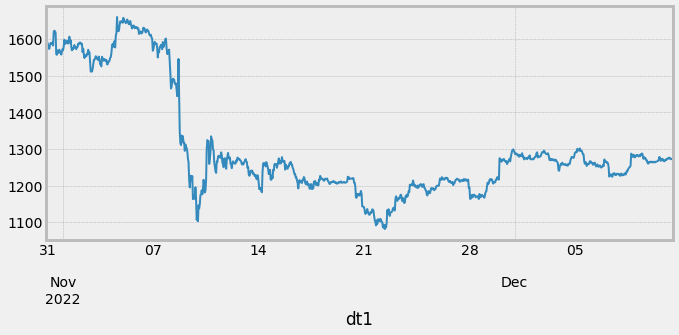

In [3]:
# get the data
url = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/USDT&period=1h'
df = pd.read_json(url)
df.columns = ['dt1','open','high','low','close','volume']
# convert to UTC+0
a = [dt.fromtimestamp(x/1000) - relativedelta(hours=3) for x in df.dt1]
df['dt1'] = a
df.to_csv('data/ETH_USDT_new.csv', index = False)
df.set_index('dt1', inplace = True)

print(df.shape)
display(df[-3:])

_ = df['close'].plot(figsize = (10,4))

### Prophet predictions

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


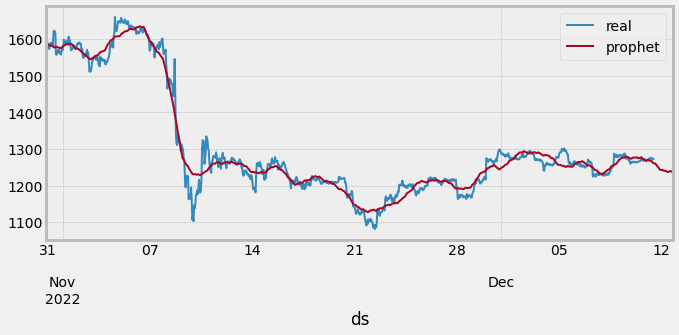

In [4]:
from prophet import Prophet

# 1) prepare dataframe
x = df.close
x = x.reset_index()
x.columns = ['ds','y']

# 2) build model
m = Prophet(weekly_seasonality=True, daily_seasonality=True, )
m.fit(x)

# # 3) predict
t1 = 30
df1 = m.make_future_dataframe(periods=t1, freq='h')
df_out = m.predict(df1)

# 4) plotting
_ = x.set_index('ds').plot(figsize = (10,4))
_ = df_out.set_index('ds')['yhat'].plot()
_ = _.legend(['real','prophet'])

### Neaural network predictions
- make differences with real values and prophet predictions
- transform to z-score (as it was on training)
- create input tensor and apply neural network model to that tensor to make predictions
- transform predictions inversed way (from z-score and add prophet predictions)

In [5]:
# 1) make differences
df_preds = df_out.set_index('ds')[['yhat']]
df_preds.insert(0,'y',np.nan)
df_preds['y'] = x.set_index('ds').y
df_preds['y_diff'] = df_preds.y - df_preds.yhat
# the last available values
data = df_preds.y_diff.values[:-t1]

In [6]:
# 2) transform to z-score (as it was on training)
data_mean = 0.011
data_std  = 197.32
data = (data - data_mean) / data_std

In [7]:
# 3) create input tensor and apply neural network model to that tensor to make predictions
n = 24*7
x = data[-n:].reshape(1,n,1)

from keras.models import load_model
model = load_model('develop/models/lstm_16.h5')
y_pred = model.predict(x)

In [8]:
# 4) inverse transform
y_pred = y_pred*data_std + data_mean

# find first index of predictions (when we trained we have 3 hours holdout period)
filt = df_preds['y_diff'].isnull()
ind = df_preds[filt][HOLDOUT:].index[:12]
pred = pd.Series(y_pred[0], index = ind)

df_preds['y_diff2'] = pred
df_preds['ypred'] = df_preds.y_diff2 + df_preds.yhat

del df_preds['y_diff']
del df_preds['y_diff2']

df_preds.rename(columns = {
    'y': 'real',
    'yhat': 'prophet',
    'ypred': 'network',
}, inplace = True)

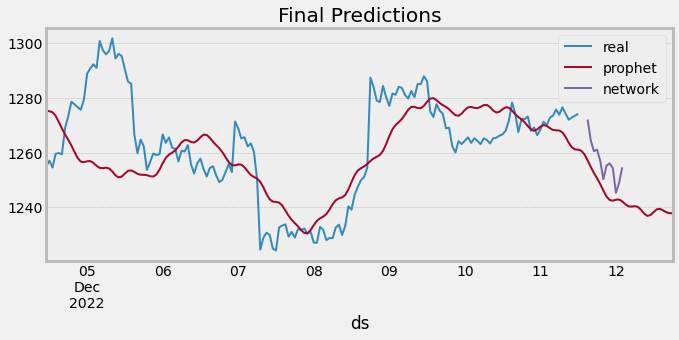

In [18]:
# plotting
_ = df_preds[-200:].plot(figsize = (10,4), title = 'Final Predictions')

### Output for Ocean

In [10]:
filt = ~df_preds['network'].isnull()
x_out = df_preds[filt].network

x_out = str(list(x_out.map(lambda x: round(x,3)))).replace(' ','')
print(x_out)
filename = 'data/eth_predict.csv'
fout = open(filename, 'w')
fout.write(x_out)
fout.close()

[1272.041,1264.437,1260.517,1261.095,1257.016,1250.272,1255.211,1256.049,1254.364,1245.348,1248.975,1254.647]


### Check predictions (after we will get the new dataset)

In [11]:
# get the new real values
url = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/USDT&period=1h'
df = pd.read_json(url)
df.columns = ['dt1','open','high','low','close','volume']
# convert to UTC+0
a = [dt.fromtimestamp(x/1000) - relativedelta(hours=3) for x in df.dt1]
df['dt1'] = a
df.set_index('dt1', inplace = True)

df_preds['real'] = df['close']

In [16]:
# plotting
# _ = df_preds[-200:].plot(figsize = (10,4))

In [17]:
# # evaluation metrics
# def ts_metrics(y_true, y_pred):
#     return {
#         'mae': metrics.mean_absolute_error(y_true, y_pred),
#         # 'mse': metrics.mean_squared_error(y_true, y_pred),
#         'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
#         # 'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
#         'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
#     }

# filt = ~df_preds['network'].isnull()

# print(ts_metrics(df_preds[filt]['real'], df_preds[filt]['prophet']))
# print(ts_metrics(df_preds[filt]['real'], df_preds[filt]['network']))

# # results
# df_out = pd.DataFrame(out1)
# df_out = -df_out
# df_out['method'] = out2
# df_out.style.background_gradient(cmap='RdYlGn')